In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datasets
import torch
from train import get_model_class
from util import convert_to_tensor
from similarity_metrics import get_top_k, average_pairwise_score, top_k_sa, top_k_cdc, top_k_consistency
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [2]:
random_sources = ['rs', 'loo']

In [3]:
name = 'heloc'  # or 'german'
n_models = 100  # 1000 for german if needed
trainset, testset = datasets.load_dataset(name)

X_test, y_test = testset.data.numpy(), testset.labels.numpy()
n_inputs, input_size = X_test.shape
model_args = [input_size, datasets.tabular.layers[name]]
directory = f'models/{name}'
directory

'models/heloc'

### Compute and save predictions from models

In [4]:
model_class = get_model_class(name)
for random_source in random_sources:
    for i in range(n_models):
        model = model_class(*model_args)
        state_dict = torch.load(f'{directory}/{random_source}_model_{i}.pth')
        model.load_state_dict(state_dict)
        pred = model.predict(X_test)
        np.save(f'{directory}/{random_source}_preds_{i}.npy', pred)

### Compute and save gradients from models

In [5]:
model_class = get_model_class(name)
for random_source in random_sources:
    for i in range(n_models):
        model = model_class(*model_args)
        state_dict = torch.load(f'{directory}/{random_source}_model_{i}.pth')
        model.load_state_dict(state_dict)
        # Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
        grads = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)
        np.save(f'{directory}/{random_source}_grads_{i}.npy', grads)

### Path to Glory

In [13]:
# Ensemble sizes
ensemble_sizes = np.arange(0, 101, 10)[1:]

# Test point indices
test_idx = range(100)
x = X_test[test_idx]

# Random source
random_source = random_sources[0]

# Number of ensembles to sample for each ensemble size
n_trials = 10

# Top-k features to consider
k = 5

# Store no. inputs and no. features
n_inputs, n_features = X_test.shape

In [14]:
random_sources

['rs', 'loo']

In [15]:
from similarity_metrics import top_k_experiment

In [16]:
SA = np.zeros((len(random_sources), len(ensemble_sizes), len(test_idx)))
SA_avg = np.zeros((len(random_sources), len(ensemble_sizes), len(test_idx)))
SA_norm_avg = np.zeros((len(random_sources), len(ensemble_sizes), len(test_idx)))
SA_smooth = np.zeros((len(random_sources), len(ensemble_sizes), len(test_idx)))
for r, random_source in enumerate(random_sources):
    if r in [0]:
        print(random_source)
        outputs = top_k_experiment(ensemble_sizes, n_trials, test_idx, k, x,
                                   n_models, name, model_args, random_source)

        topk_counts_signed, signs_counts_signed,\
        topk_avg, signs_avg, topk_norm_avg, signs_norm_avg,\
        topk_smooth, signs_smooth = outputs
        for i in tqdm(range(len(ensemble_sizes))):
            tk_count = topk_counts_signed[i]
            sign_count = signs_counts_signed[i]
            
            SA[r, i] = average_pairwise_score(tk_count, sign_count, top_k_sa)
            SA_avg[r, i] = average_pairwise_score(topk_avg[i], signs_avg[i], top_k_sa)
            SA_norm_avg[r, i] = average_pairwise_score(topk_norm_avg[i], signs_norm_avg[i], top_k_sa)
            SA_smooth[r, i] = average_pairwise_score(topk_smooth[i], signs_smooth[i], top_k_sa)

rs


10it [01:21,  8.19s/it]
100%|██████████| 10/10 [00:01<00:00,  7.54it/s]


### Plot Metrics (need to adjust similarity_metrics.py to suit our uses)

In [17]:
# Count-based
SA = np.zeros((len(ensemble_sizes), len(test_idx)))
#consistencies = np.zeros((len(counts), len(test_idx)))
#CDC = np.zeros((len(counts), len(test_idx)))
#SSA = np.zeros((len(counts), len(test_idx)))

# Average/norm-average/smooth ensemble
SA_avg = np.zeros((len(ensemble_sizes), len(test_idx)))
SA_norm_avg = np.zeros((len(ensemble_sizes), len(test_idx)))
SA_smooth = np.zeros((len(ensemble_sizes), len(test_idx)))

for i in tqdm(range(len(ensemble_sizes))):
    # Counting-based feature attributions
    tk_count = topk_counts_signed[i]
    sign_count = signs_counts_signed[i]
    #consistencies[i] = top_k_consistency(tk_count)
    #CDC[i] = average_pairwise_score(tk_count, sign_count, top_k_cdc)

    # Compute Signed-Agreement
    SA[i] = average_pairwise_score(tk_count, sign_count, top_k_sa)
    SA_avg[i] = average_pairwise_score(topk_avg[i], signs_avg[i], top_k_sa)
    SA_norm_avg[i] = average_pairwise_score(topk_norm_avg[i], signs_norm_avg[i], top_k_sa)
    SA_smooth[i] = average_pairwise_score(topk_smooth[i], signs_smooth[i], top_k_sa)

100%|██████████| 10/10 [00:01<00:00,  7.16it/s]


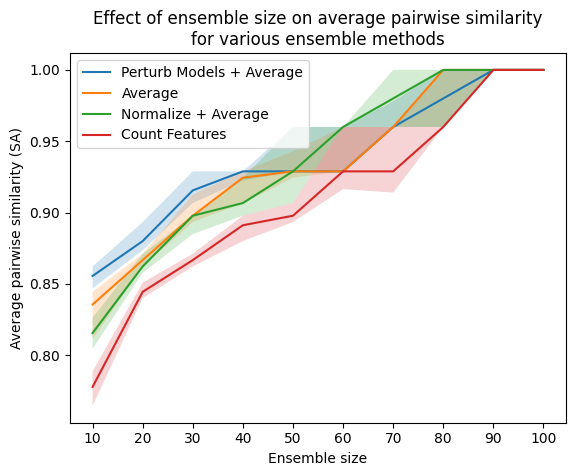

In [20]:
titles = ['Perturb Models + Average', 'Average', 'Normalize + Average', 'Count Features']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.45, 0.5, 0.55], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.xticks(ensemble_sizes)
plt.ylabel('Average pairwise similarity (SA)')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend()
plt.show()

In [28]:
SA_smooth[0].shape

(10, 200)

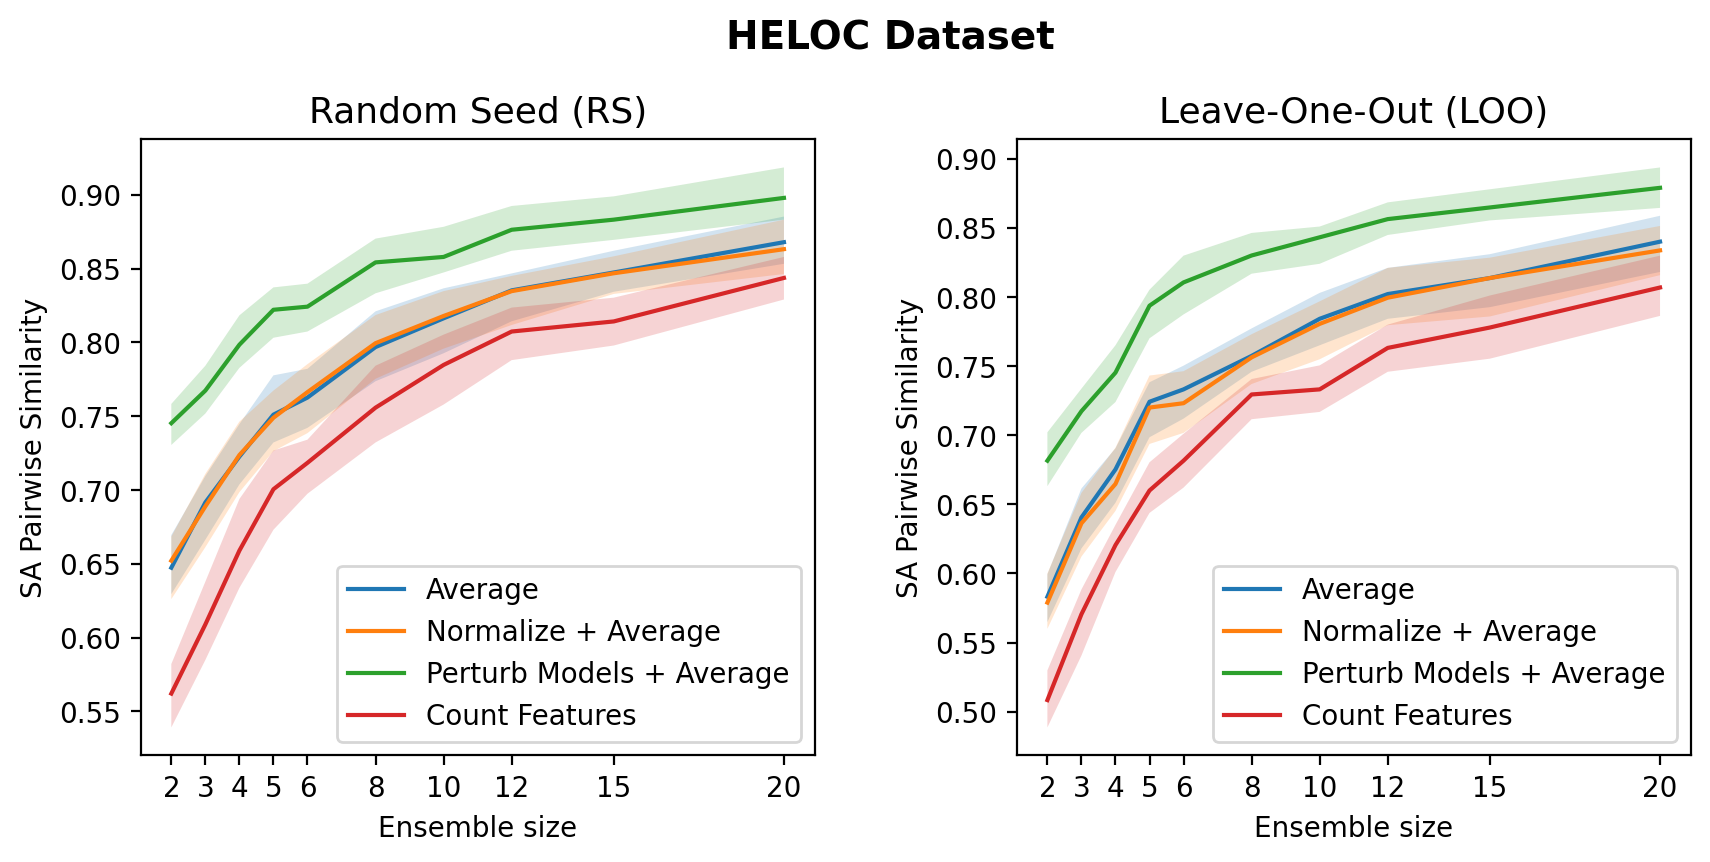

In [61]:
titles = ['Average', 'Normalize + Average', 'Perturb Models + Average', 'Count Features']
subtitles = ['Random Seed (RS)', 'Leave-One-Out (LOO)']
# Two plots as above, side-by-side
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
plt.subplots_adjust(wspace=0.3)
plt.suptitle('HELOC Dataset', fontweight='bold', fontsize=14, y=1.03)
for r, random_source in enumerate(random_sources):
    for i, metric in enumerate([SA_avg[r], SA_norm_avg[r], SA_smooth[r], SA[r]]):
        # Error bars represent different inputs
        q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
        ax[r].plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
        ax[r].fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
    ax[r].set_xlabel('Ensemble size')
    ax[r].set_xticks(ensemble_sizes)
    ax[r].set_ylabel('SA Pairwise Similarity')
    ax[r].set_title(subtitles[r], fontsize=13)
    ax[r].legend()

# Junk

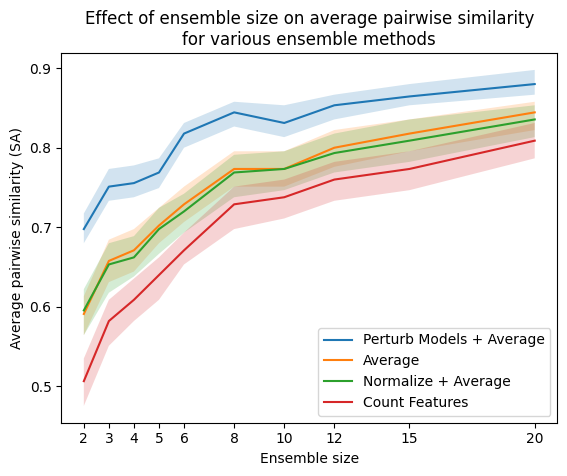

In [ ]:
titles = ['Perturb Models + Average', 'Average', 'Normalize + Average', 'Count Features']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.xticks(ensemble_sizes)
plt.ylabel('Average pairwise similarity (SA)')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend()
plt.show()

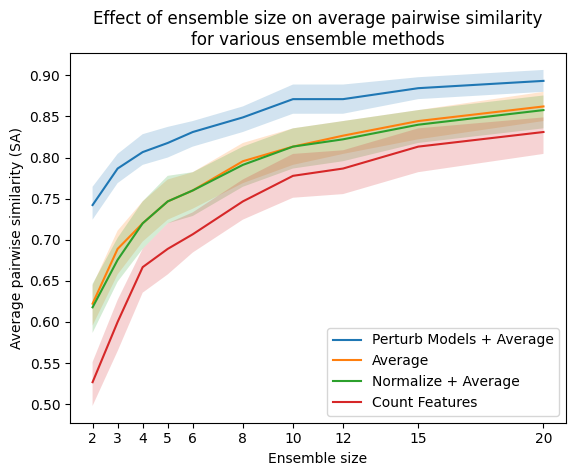

In [ ]:
titles = ['Perturb Models + Average', 'Average', 'Normalize + Average', 'Count Features']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.xticks(ensemble_sizes)
plt.ylabel('Average pairwise similarity (SA)')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend()
plt.show()

In [95]:
n_singles = [10, 20, 30, 40, 50]
sa_single = np.zeros((len(n_singles), len(test_idx)))
for i, n_single in tqdm(enumerate(n_singles)):
    grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in range(n_single)])
    grads = grads[:, test_idx]
    tk_single, s_single = get_top_k(k, grads, return_sign=True)
    sa_single[i] = average_pairwise_score(tk_single, s_single, top_k_sa)

5it [00:17,  3.43s/it]


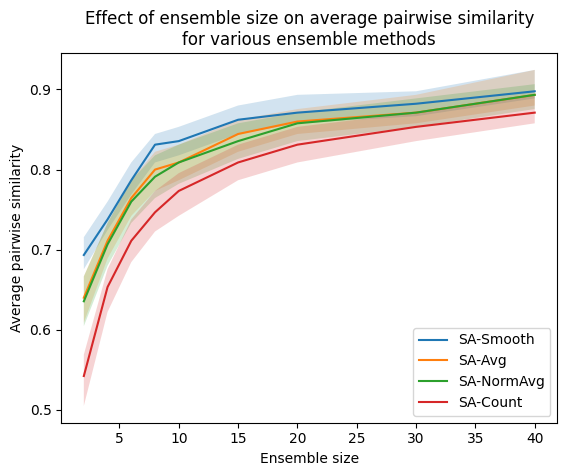

In [ ]:
titles = ['SA-Smooth', 'SA-Avg', 'SA-NormAvg', 'SA-Count']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.ylabel('Average pairwise similarity')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend()
plt.show()

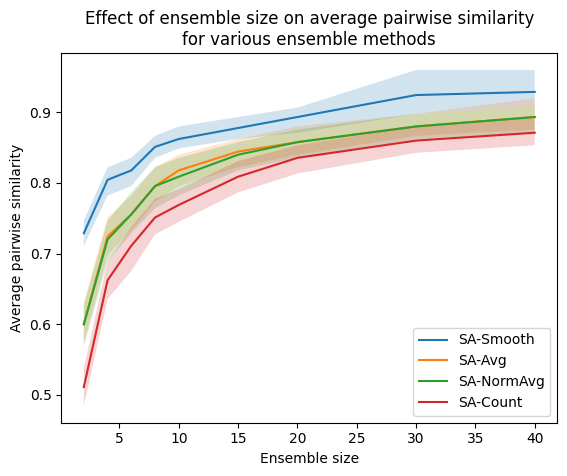

In [ ]:
titles = ['SA-Smooth', 'SA-Avg', 'SA-NormAvg', 'SA-Count']
for i, metric in enumerate([SA_smooth, SA_avg, SA_norm_avg, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.4, 0.5, 0.6], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.ylabel('Average pairwise similarity')
plt.title('Effect of ensemble size on average pairwise similarity\nfor various ensemble methods')
plt.legend()
plt.show()

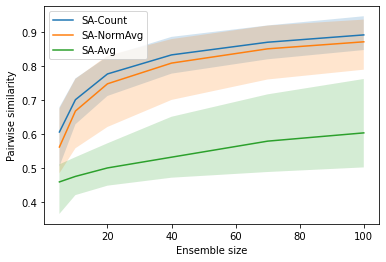

In [ ]:
titles = ['SA-Count', 'SA-NormAvg', 'SA-Avg']
for i, metric in enumerate([SA, SA_norm_avg, SA_avg]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.25, 0.5, 0.75], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.ylabel('Pairwise similarity')
plt.legend()
plt.show()

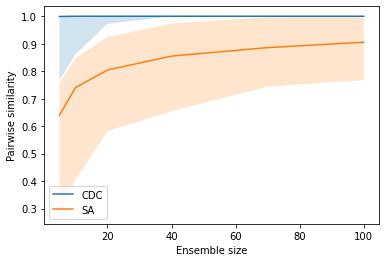

In [ ]:
titles = ['CDC', 'SA']
for i, metric in enumerate([CDC, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.1, 0.5, 0.9], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.ylabel('Pairwise similarity')
plt.legend()
plt.show()

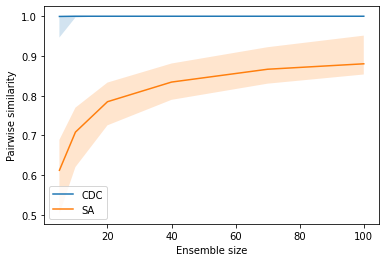

In [ ]:
titles = ['CDC', 'SA']
for i, metric in enumerate([CDC, SA]):
    # Error bars represent different inputs
    q = np.quantile(metric, [0.25, 0.5, 0.75], axis=1)
    plt.plot(ensemble_sizes, q[1], label=titles[i])  # plot 50% quantile
    plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)  # fill between 25% and 75% quantiles
plt.xlabel('Ensemble size')
plt.ylabel('Pairwise similarity')
plt.legend()
plt.show()

In [305]:
# 1 row, no. metrics columns
# metrics: consistency, SA, CDC, SSA
metrics = [consistencies, SA, CDC, SSA]

(6, 100)

### Misc Plots

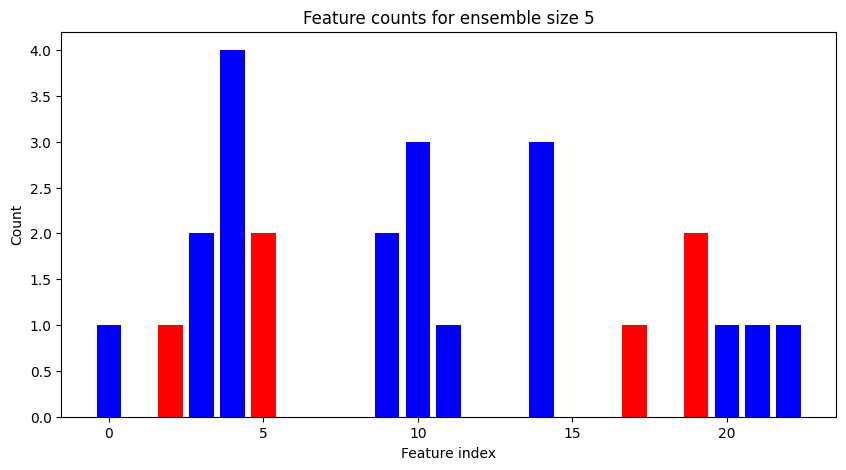

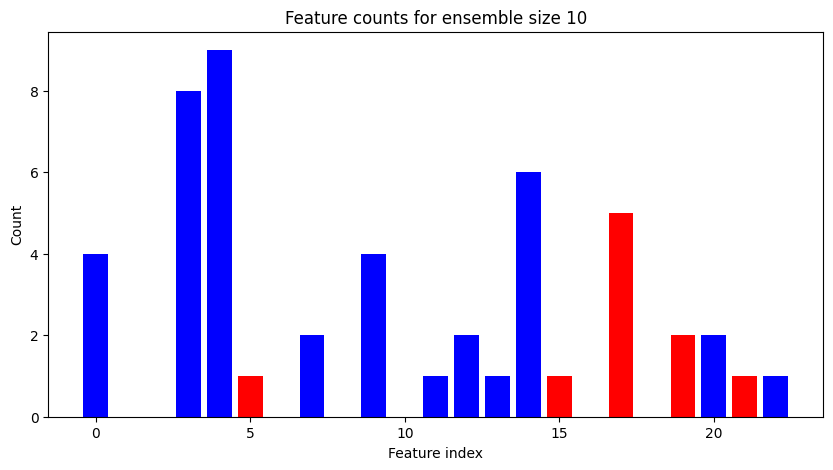

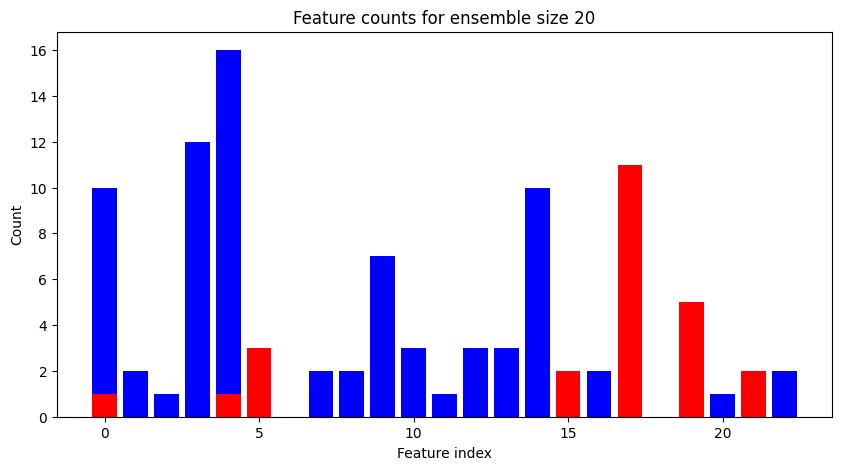

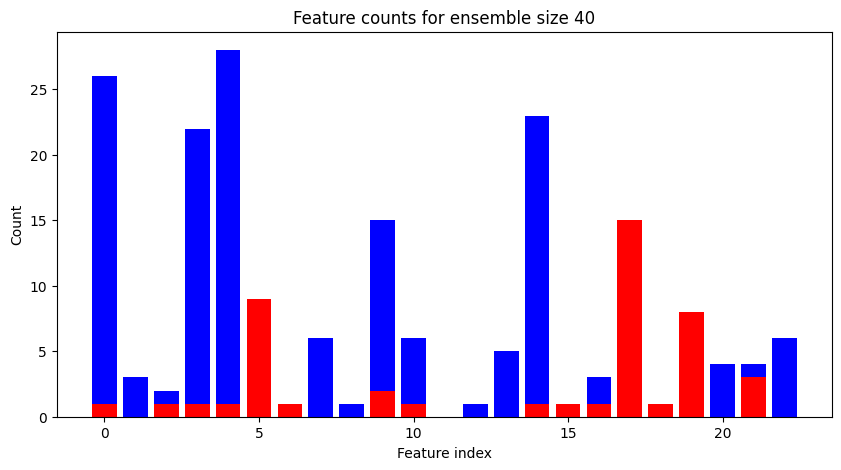

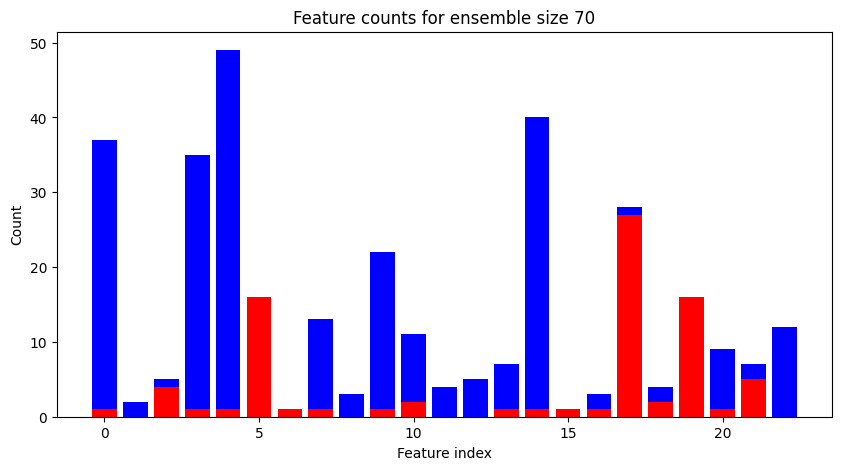

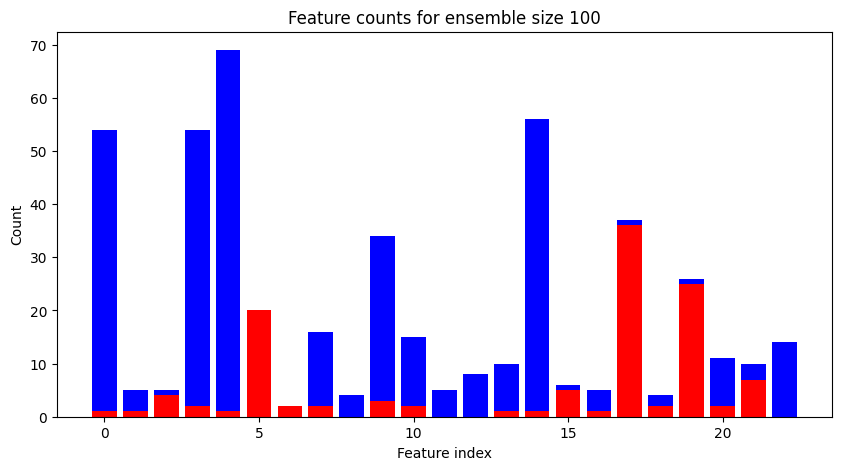

In [304]:
for i, ensemble_size in enumerate(ensemble_sizes):
    p, n = counts_pos[i][0,0], counts_neg[i][0,0]
    # Plot bar chart of feature counts, with positive and negative counts stacked
    plt.figure(figsize=(10, 5))
    plt.bar(range(n_features), p + n, color='blue')
    plt.bar(range(n_features), n, color='red')
    plt.title(f'Feature counts for ensemble size {ensemble_size}')
    plt.xlabel('Feature index')
    plt.ylabel('Count')
    plt.show()

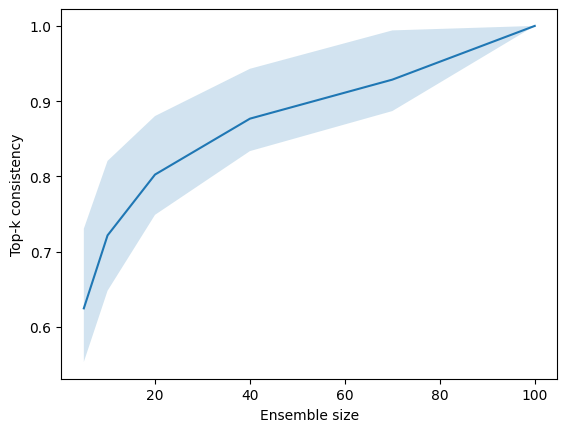

In [256]:
q = np.quantile(consistencies, [0.25, 0.5, 0.75], axis=1)
# Plot 50% quantile
plt.plot(ensemble_sizes, q[1], label='50% quantile')
# Fill between 25% and 75% quantiles
plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)
plt.xlabel('Ensemble size')
plt.ylabel('Top-k consistency')
plt.show()

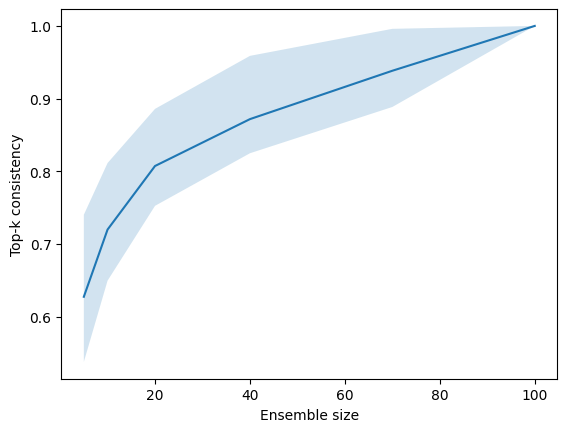

In [ ]:
q = np.quantile(consistencies, [0.25, 0.5, 0.75], axis=1)
# Plot 50% quantile
plt.plot(ensemble_sizes, q[1], label='50% quantile')
# Fill between 25% and 75% quantiles
plt.fill_between(ensemble_sizes, q[0], q[2], alpha=0.2)
plt.xlabel('Ensemble size')
plt.ylabel('Top-k consistency')
plt.show()

### How to load/visualize gradients

In [44]:
# Set ensemble size
size_ensemble = 10

In [45]:
# Randomly sample size_ensemble indices from 0 to n_models
indices = np.random.choice(n_models, size_ensemble, replace=False)
indices

array([ 5, 11, 15, 49, 41, 93,  7, 52, 96, 69])

In [46]:
# Load predictions and gradients for models with those indices
preds = np.array([np.load(f'{directory}/{random_source}_preds_{i}.npy') for i in indices])
grads = np.array([np.load(f'{directory}/{random_source}_grads_{i}.npy') for i in indices])

In [47]:
# grads has size (size_ensemble, n_inputs, n_features) for tabular data
n_inputs, n_features = grads.shape[1:]
n_inputs, n_features

(1975, 23)

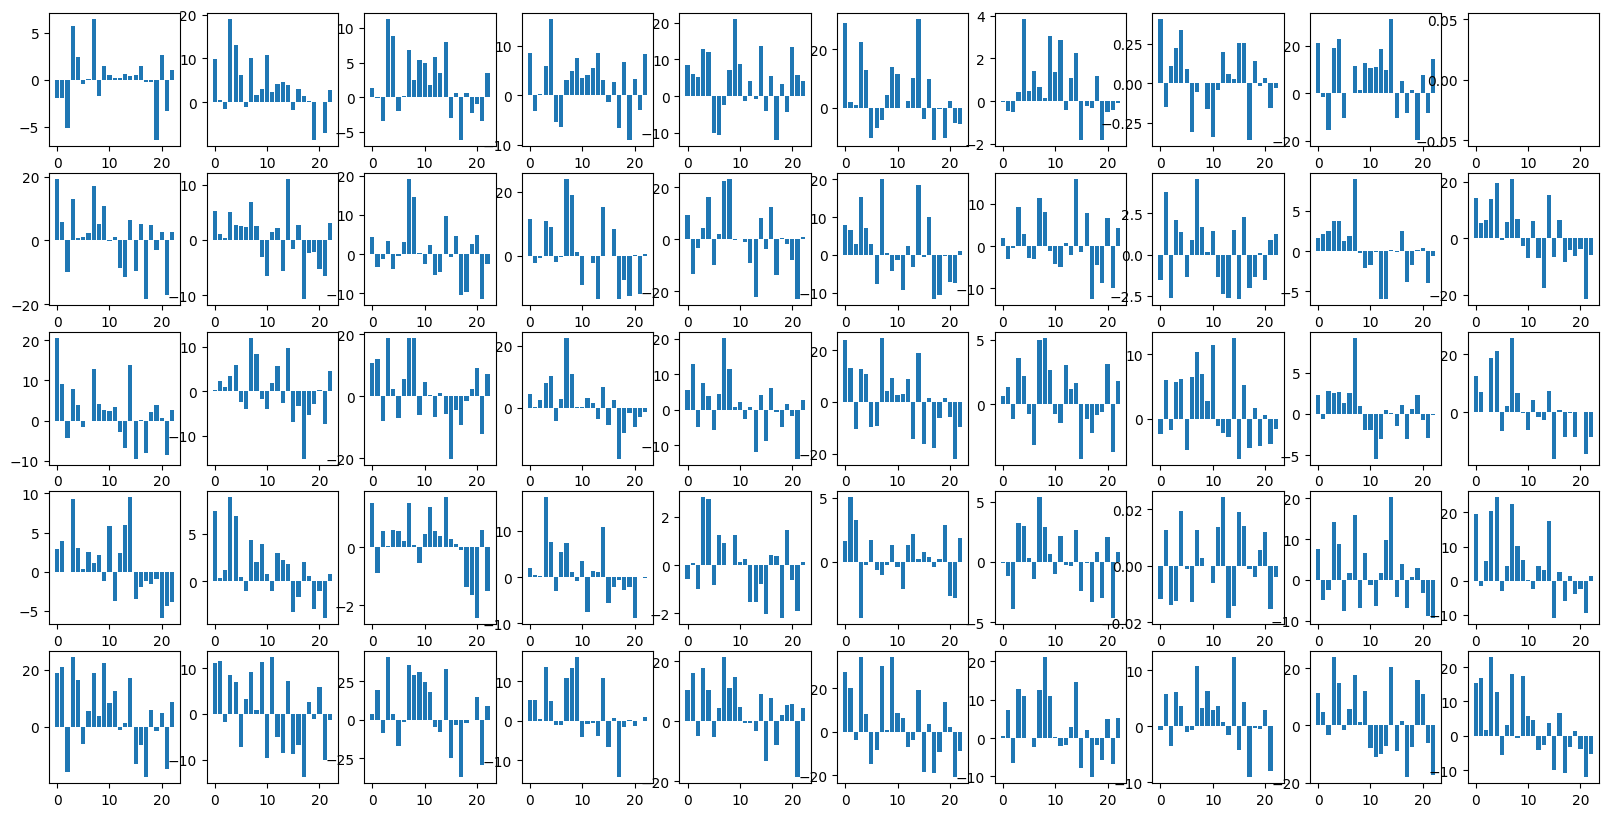

In [48]:
# Visualize gradients for each of the models in the ensemble for first 5 inputs
# Rows are inputs, columns are models
rows = 5
fig, axs = plt.subplots(rows, size_ensemble, figsize=(rows*4, size_ensemble), dpi=100)
for i in range(5):
    for j in range(size_ensemble):
        axs[i,j].bar(range(n_features), grads[j,i])
plt.show()

Okay so some gradients are zero... moreso if you do softmax gradient instead of logit gradient

Might just be a floating point error (could try float64 instead of float32 but will double the storage size)

softmax gradient and logit gradient should be the same (?), just softmax is magnitudes smaller

### Top k and comparisons

In [40]:
print("(no. models in ensemble, no. test inputs, no. features)")
print(grads.shape)

(no. models in ensemble, no. test inputs, no. features)
(10, 1975, 23)


In [41]:
from similarity_metrics import get_top_k

In [53]:
grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in indices])
grads.shape

(100, 1975, 23)

In [54]:
from tqdm import tqdm

In [155]:
from similarity_metrics import get_top_k

In [158]:
tk, s = get_top_k(k=5, X=grads, return_sign=True)

In [161]:
grads.shape

(100, 10, 23)

In [163]:
grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in model_idx])
grads = grads[:, test_idx]
grads.shape

(100, 10, 23)

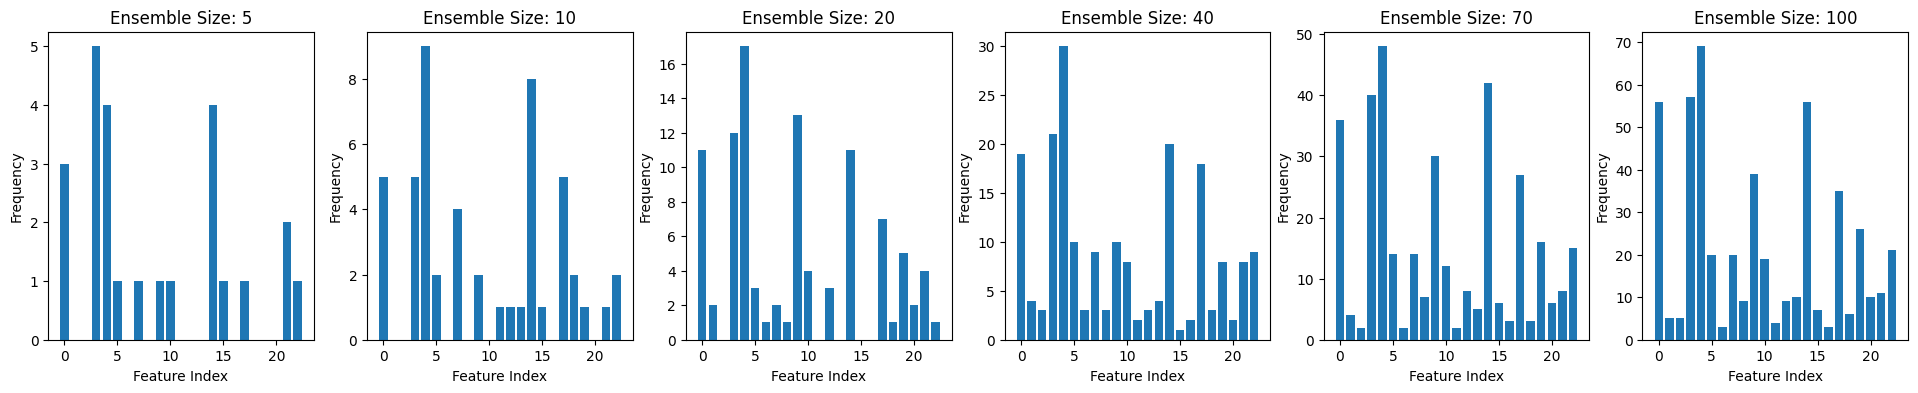

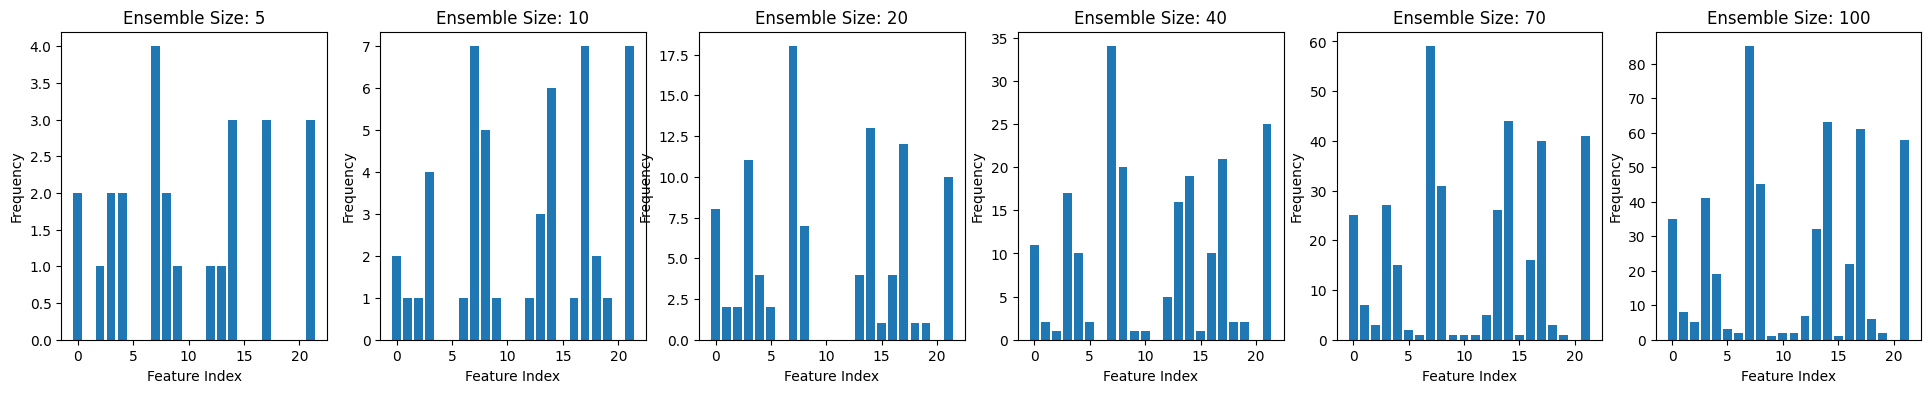

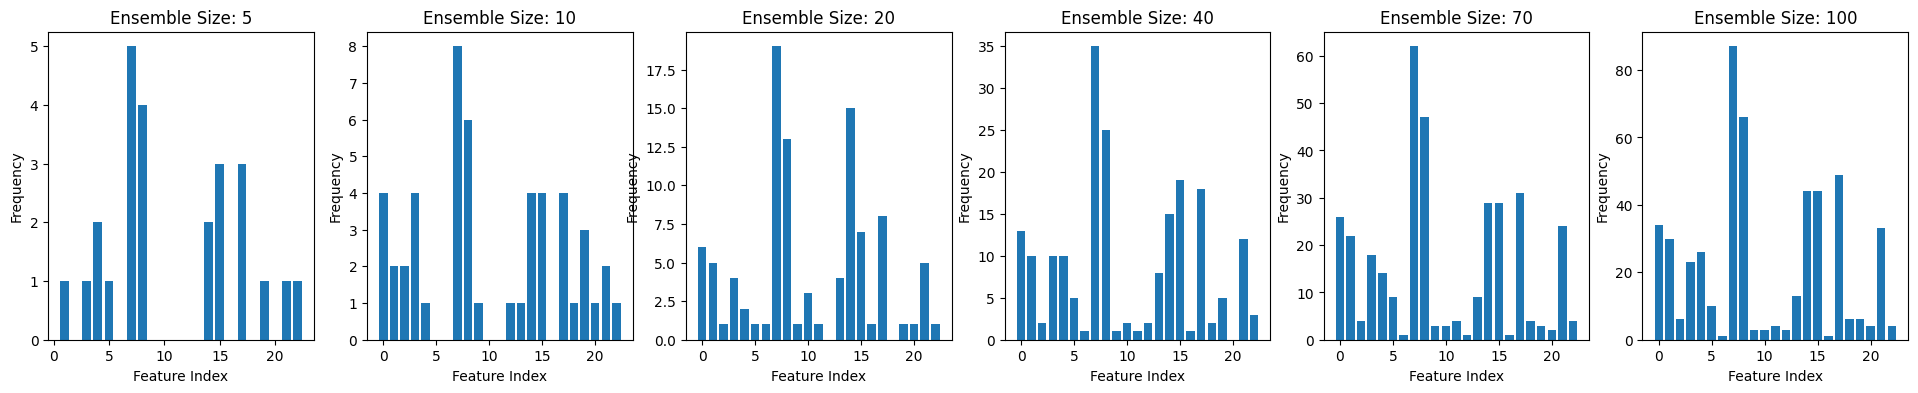

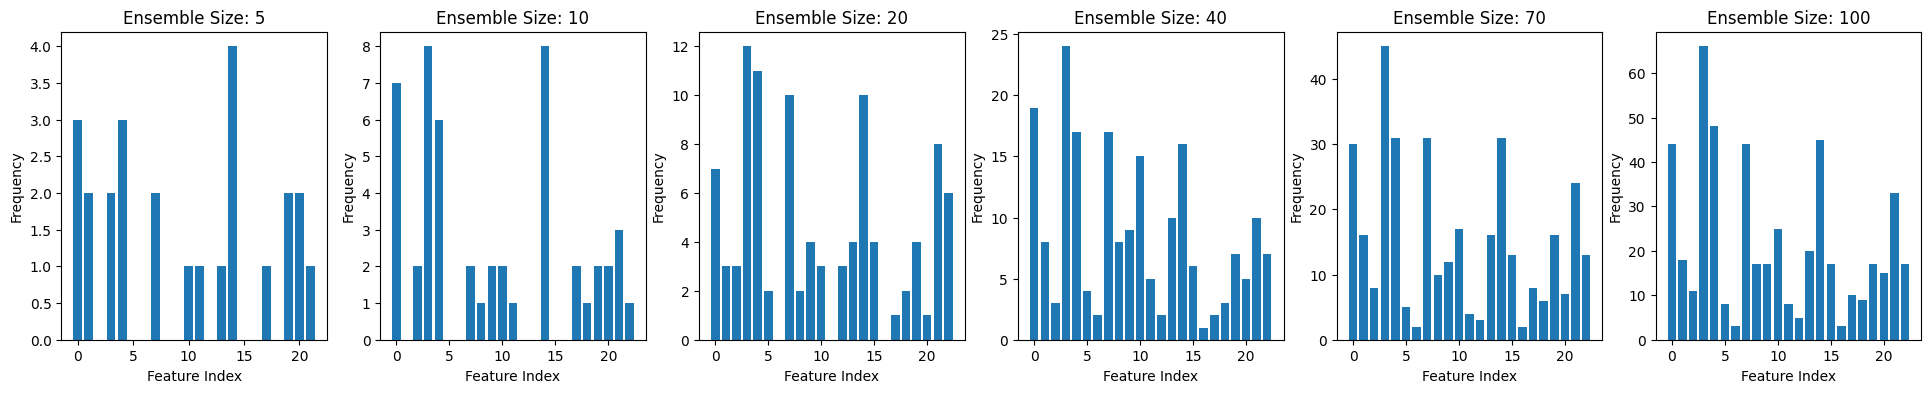

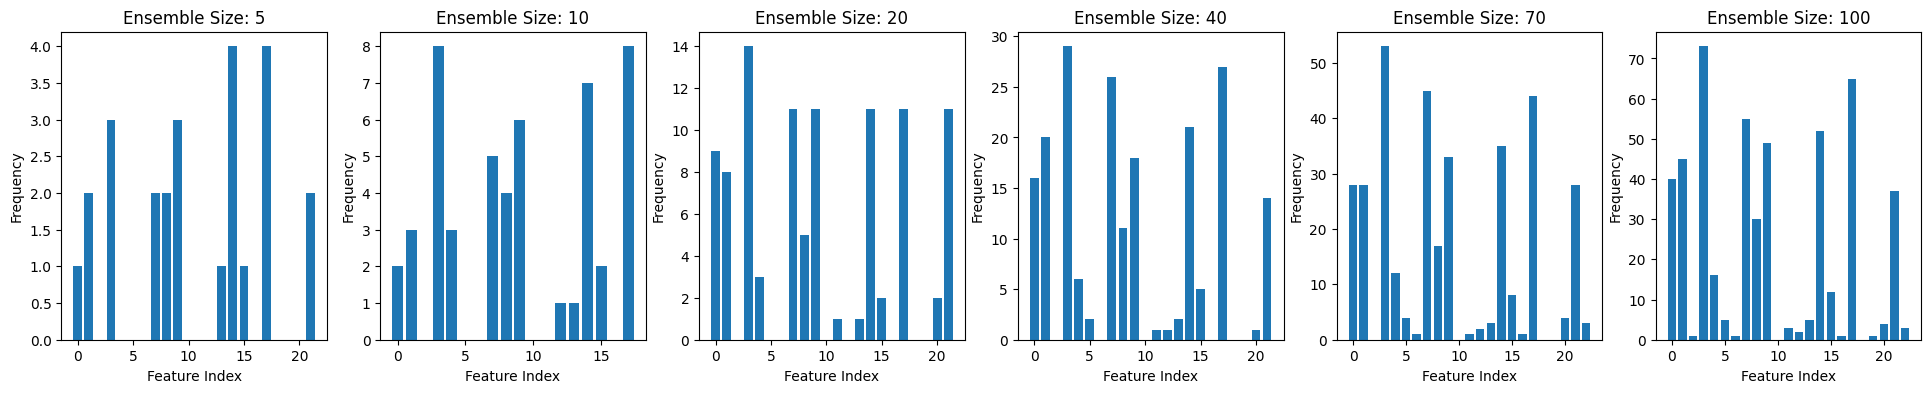

In [49]:
ensemble_sizes = [5, 10, 20, 40, 70, 100]
# Randomly sample size_ensemble indices from 0 to n_models for each ensemble size, load grads, and get top k grads
top5 = []
n_test = 5
counts = np.zeros((n_test, len(ensemble_sizes), n_features))
for i in range(n_test):
    fig, axs = plt.subplots(1, len(ensemble_sizes), figsize=(len(ensemble_sizes)*4, 4), dpi=100)
    for j, size_ensemble in enumerate(ensemble_sizes):
        indices = np.random.choice(n_models, size_ensemble, replace=False)  # should do this many times
        grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in indices])
        top5.append(np.array([get_top_k(grads[idx], k=5) for idx in range(size_ensemble)]))
        un, co = np.unique(top5[j][:, i].flatten(), return_counts=True)
        axs[j].bar(un, co)
        axs[j].set_xlabel('Feature Index')
        axs[j].set_ylabel('Frequency')
        axs[j].set_title(f'Ensemble Size: {size_ensemble}')
        counts[i, j, un] = co
    plt.show()

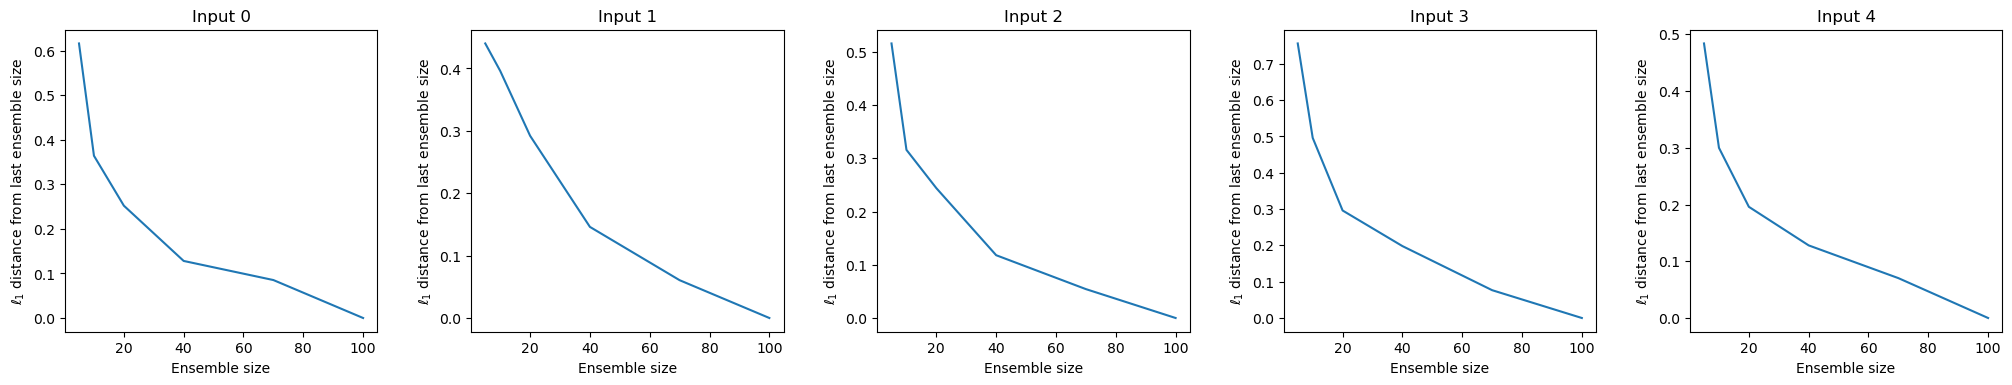

In [41]:
fig, axs = plt.subplots(1, n_test, figsize=(n_test*5, 4), dpi=100)
plt.subplots_adjust(wspace=0.3)
for i in range(n_test):
    counts_norm = counts[i]/np.sum(counts[i], axis=1)[:, None]
    axs[i].plot(ensemble_sizes, np.linalg.norm(counts_norm-counts_norm[-1], axis=1, ord=1))
    axs[i].set_xlabel('Ensemble size')
    axs[i].set_ylabel('$\ell_1$ distance from last ensemble size')
    axs[i].set_title(f'Input {i}')
plt.show()

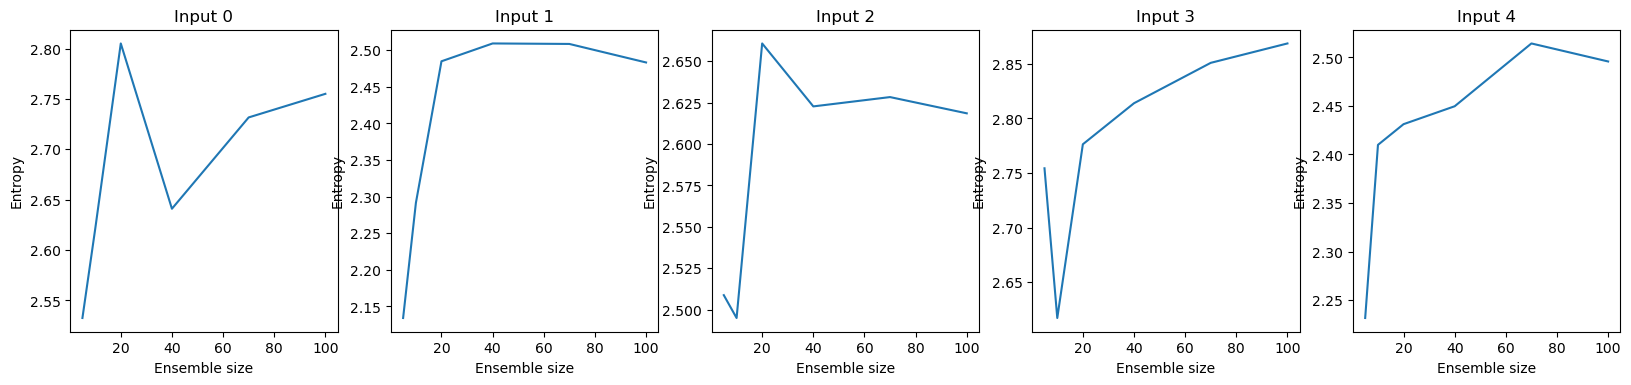

In [20]:
# Compute entropy of each feature distribution in counts
from scipy.stats import entropy
# Plot entropy of counts for each input
fig, axs = plt.subplots(1, n_test, figsize=(n_test*4, 4), dpi=100)
for i in range(n_test):
    full_counts_norm = counts[i, -1]/np.sum(counts[i, -1])
    counts[0]/np.sum(counts[0], axis=1)[:, None]
    axs[i].plot(ensemble_sizes, entropy(counts[i], axis=1))
    axs[i].set_xlabel('Ensemble size')
    axs[i].set_ylabel('Entropy')
    axs[i].set_title(f'Input {i}')
plt.show()

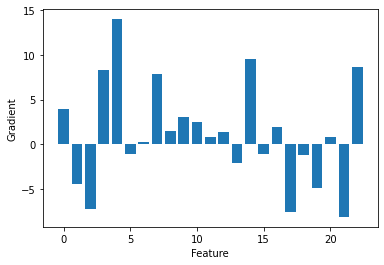

In [65]:
# Function for a single gradient plot
def plot_grad(grad, k=-1):
    # Optional top k gradients by absolute value
    if k > 0:
        grad = grad[np.argsort(np.abs(grad))[-k:]]
    plt.bar(range(grad.shape[0]), grad)
    plt.ylabel('Gradient')
    plt.xlabel('Feature')
    plt.show()

plot_grad(grads[0,0])